In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libs

In [2]:
!pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.9/35.9 MB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 17.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.5 which is incompatible.


In [11]:
import os
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import LabelEncoder
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import StandardScaler

# Ploting Utils

In [7]:
def plot_learning_curves(history):
  # Візуалізація кривих точності
  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  # Візуалізація кривих втрат
  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.show()

In [31]:
def plot_conf_matrix(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred)

  # Adjusting the figure size for better visibility
  plt.figure(figsize=(12, 12))  # Increase the size of the figure

  # Create a ConfusionMatrixDisplay with larger font size for labels and rotated x-axis labels
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_true))
  disp.plot(cmap=plt.cm.Blues, ax=plt.gca(), values_format='d')

  # Increase label font sizes and rotate x-axis labels
  plt.xticks(fontsize=14, rotation=45)
  plt.yticks(fontsize=14)
  plt.title(f'Confusion Matrix (Accuracy: {accuracy_score(y_true, y_pred)})', fontsize=20)
  plt.xlabel('Predicted label', fontsize=16)
  plt.ylabel('True label', fontsize=16)

  # Show the plot
  plt.show()

# Train/Test split

In [3]:
IMAGE_DATASET_PATH = '/content/drive/MyDrive/NULP/Masters/Thesis/CodeBase/asl_dataset'
KEYPOINTS_DATASET_PATH = '/content/drive/MyDrive/NULP/Masters/Thesis/CodeBase/asl_dataset_with_landmarks.csv'

In [6]:
df = pd.read_csv(KEYPOINTS_DATASET_PATH)

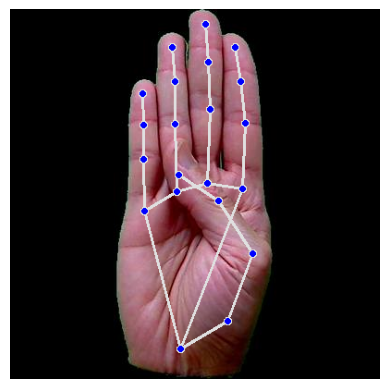

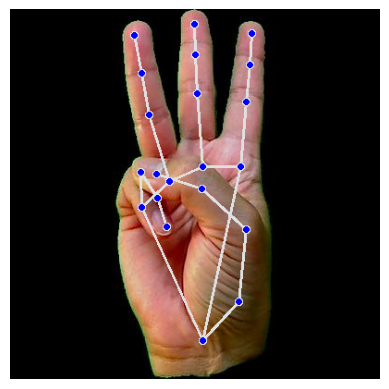

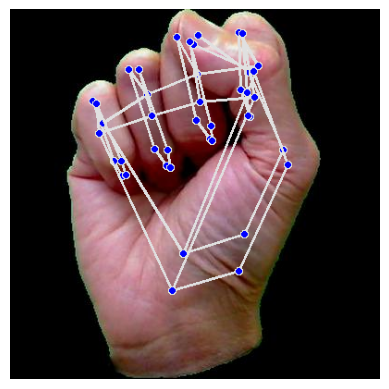

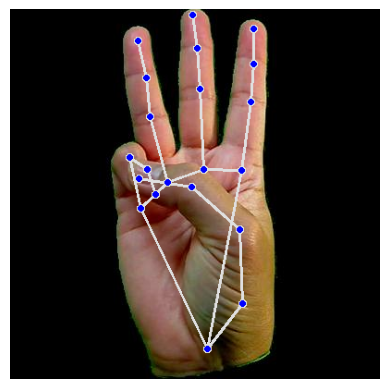

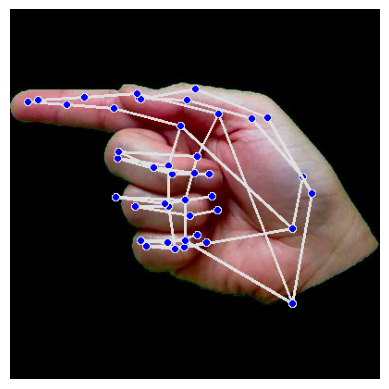

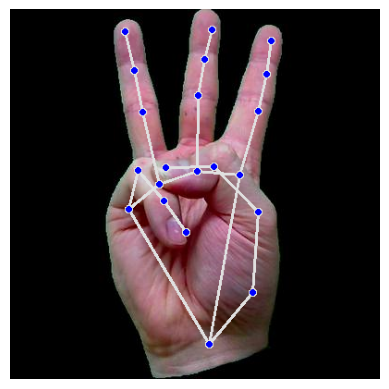

In [56]:
mp_hands = mp.solutions.hands
hands = mp_hands.Hands()
mp_draw = mp.solutions.drawing_utils

# Функція для вибору випадкових зображень
def get_random_image_path(dataset_path, n_samples=5):
    classes = sorted(os.listdir(dataset_path))
    sample_paths = []
    for _ in range(n_samples):
        random_class = random.choice(classes)
        class_path = os.path.join(dataset_path, random_class)
        if os.path.isdir(class_path):
            random_image = random.choice(os.listdir(class_path))
            image_path = os.path.join(class_path, random_image)
            sample_paths.append(image_path)
    return sample_paths

# Обробка та відображення зображень з кістяками рук
def visualize_hand_landmarks(image_paths):
    for image_path in image_paths:
        # Завантаження зображення
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Обробка зображення для виявлення рук
        result = hands.process(image_rgb)

        # Малювання кістяка руки на зображенні, якщо знайдено руку
        if result.multi_hand_landmarks:
            for hand_landmarks in result.multi_hand_landmarks:
                mp_draw.draw_landmarks(image_rgb, hand_landmarks, mp_hands.HAND_CONNECTIONS)

        # Відображення зображення з кістяком руки
        plt.imshow(image_rgb)
        plt.axis('off')
        plt.show()

# Вибір випадкових зображень для візуалізації
sample_image_paths = get_random_image_path(IMAGE_DATASET_PATH, 6)
visualize_hand_landmarks(sample_image_paths)

# Закриття ресурсу MediaPipe
hands.close()


In [8]:

# Ініціалізація LabelEncoder
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

# Розділення даних та міток
X = df.drop('label', axis=1).values
y = df['label'].values

# Розділення на тренувальний та тестовий набори
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Training samples: {X_train.shape[0]}')
print(f'Testing samples: {X_test.shape[0]}')

Training samples: 1296
Testing samples: 325


In [10]:
# Ініціалізація StandardScaler
scaler = StandardScaler()

# Навчання scaler на тренувальних даних
X_train = scaler.fit_transform(X_train)

# Застосування scaler до тестових даних
X_test = scaler.transform(X_test)

# Перетворення міток у формат one-hot encoding
y_train = to_categorical(y_train, num_classes=36)
y_test = to_categorical(y_test, num_classes=36)

# Розширення вимірів даних для використання в 1D CNN
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Initial model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)                    │ (None, 61, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 28, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ (None, 14, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 14, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 1792)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         229,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 36)                  │           4,644 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 259,108 (1012.14 KB)

 Trainable params: 259,108 (1012.14 KB)

 Non-trainable params: 0 (0.00 B)

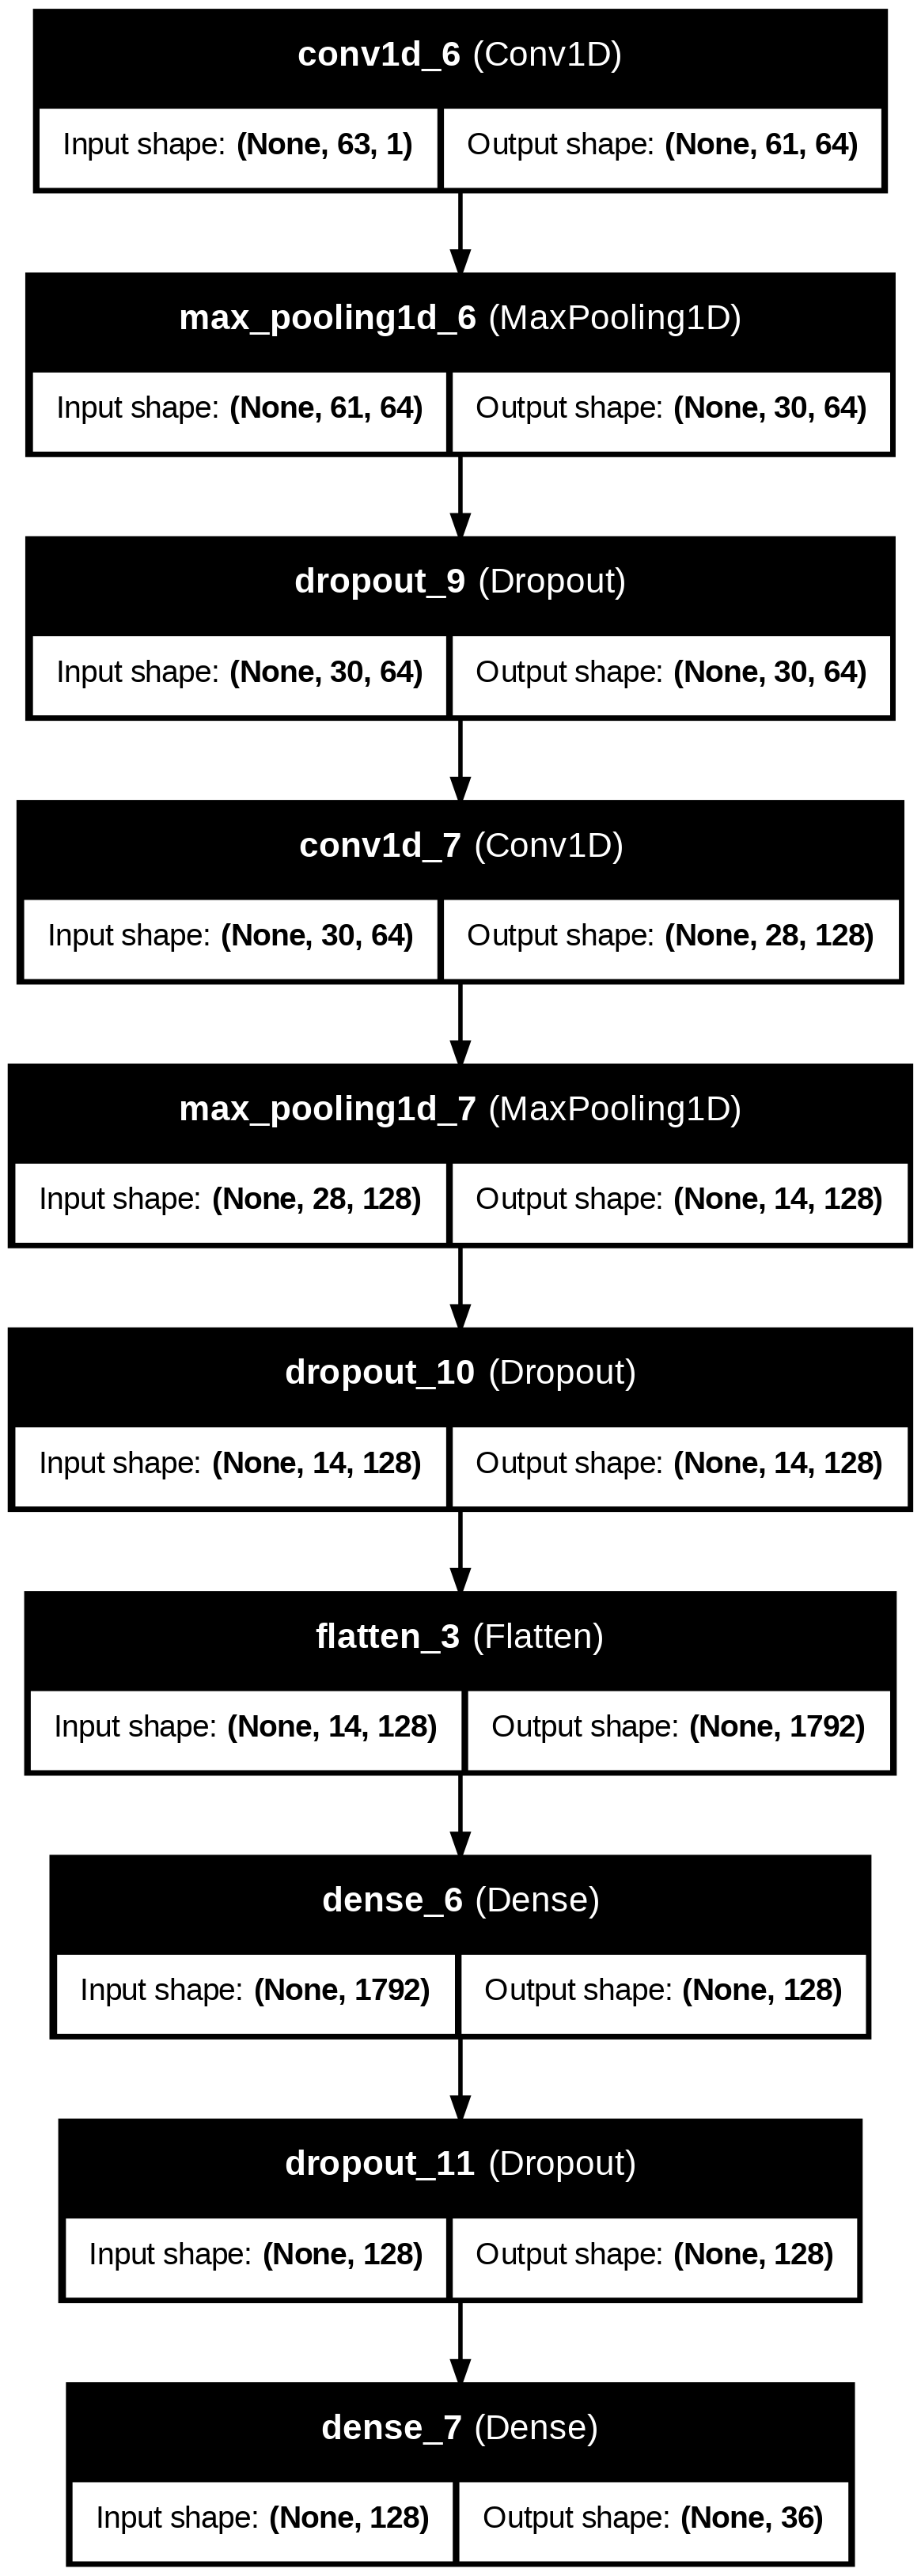

In [32]:
def get_cnn_model():
  # Створення моделі перед тренуванням
  model = Sequential()

  # Додавання згорткових шарів
  model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(0.25))

  model.add(Conv1D(128, kernel_size=3, activation='relu'))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(0.25))

  # Додавання повнозв'язкових шарів
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))

  # Вихідний шар для класифікації
  model.add(Dense(36, activation='softmax'))

  return model

model = get_cnn_model()
# Компіляція моделі
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Visualize the CNN model architecture
model.summary()

# Save model visualization to a file
plot_model(model, show_shapes=True, show_layer_names=True)

In [33]:
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=64)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.0699 - loss: 3.4933 - val_accuracy: 0.3877 - val_loss: 2.9659
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.2569 - loss: 2.8334 - val_accuracy: 0.5385 - val_loss: 2.0488
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.4271 - loss: 2.1890 - val_accuracy: 0.6862 - val_loss: 1.3450
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.5382 - loss: 1.6153 - val_accuracy: 0.7785 - val_loss: 1.0006
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.6135 - loss: 1.3082 - val_accuracy: 0.8123 - val_loss: 0.7668
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7051 - loss: 0.9851 - val_accuracy: 0.8554 - val_loss: 0.6592
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7515 - loss: 0.9010 - val_accuracy: 0.8769 - val_loss: 0.5393
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7482 - loss: 0.8073 - val_accuracy: 0.8800 - v

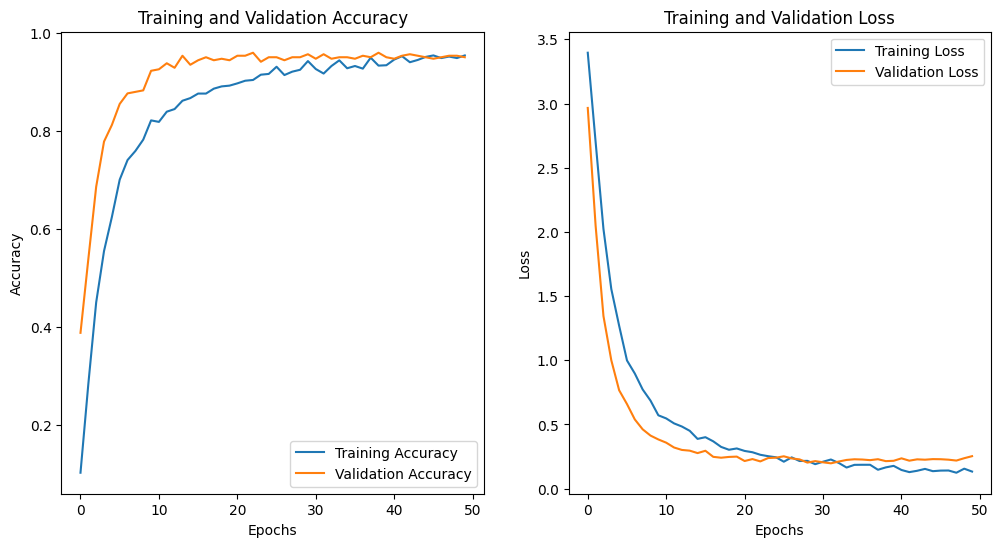

In [34]:
plot_learning_curves(history)

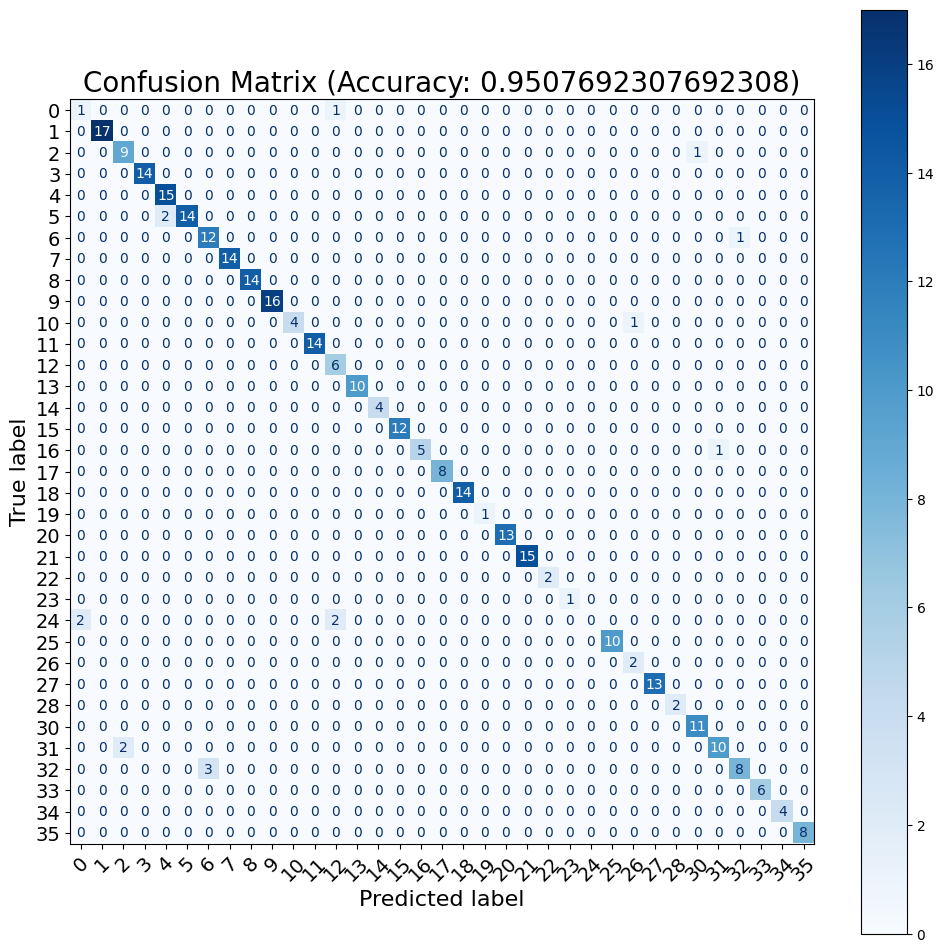

In [40]:
# Прогнозуємо на тестовому наборі
y_pred = model.predict(X_test)

# Перетворення one-hot encoded міток у вектори класів
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

plot_conf_matrix(y_true, y_pred_classes)

# Add new layers and increase neuron number

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)                    │ (None, 61, 128)             │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_8 (MaxPooling1D)       │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_9 (Conv1D)                    │ (None, 28, 256)             │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_9 (MaxPooling1D)       │ (None, 14, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 14, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_10 (Conv1D)                   │ (None, 12, 512)             │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_10 (MaxPooling1D)      │ (None, 6, 512)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 6, 512)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │       1,573,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 36)                  │          18,468 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,084,644 (7.95 MB)

 Trainable params: 2,084,644 (7.95 MB)

 Non-trainable params: 0 (0.00 B)

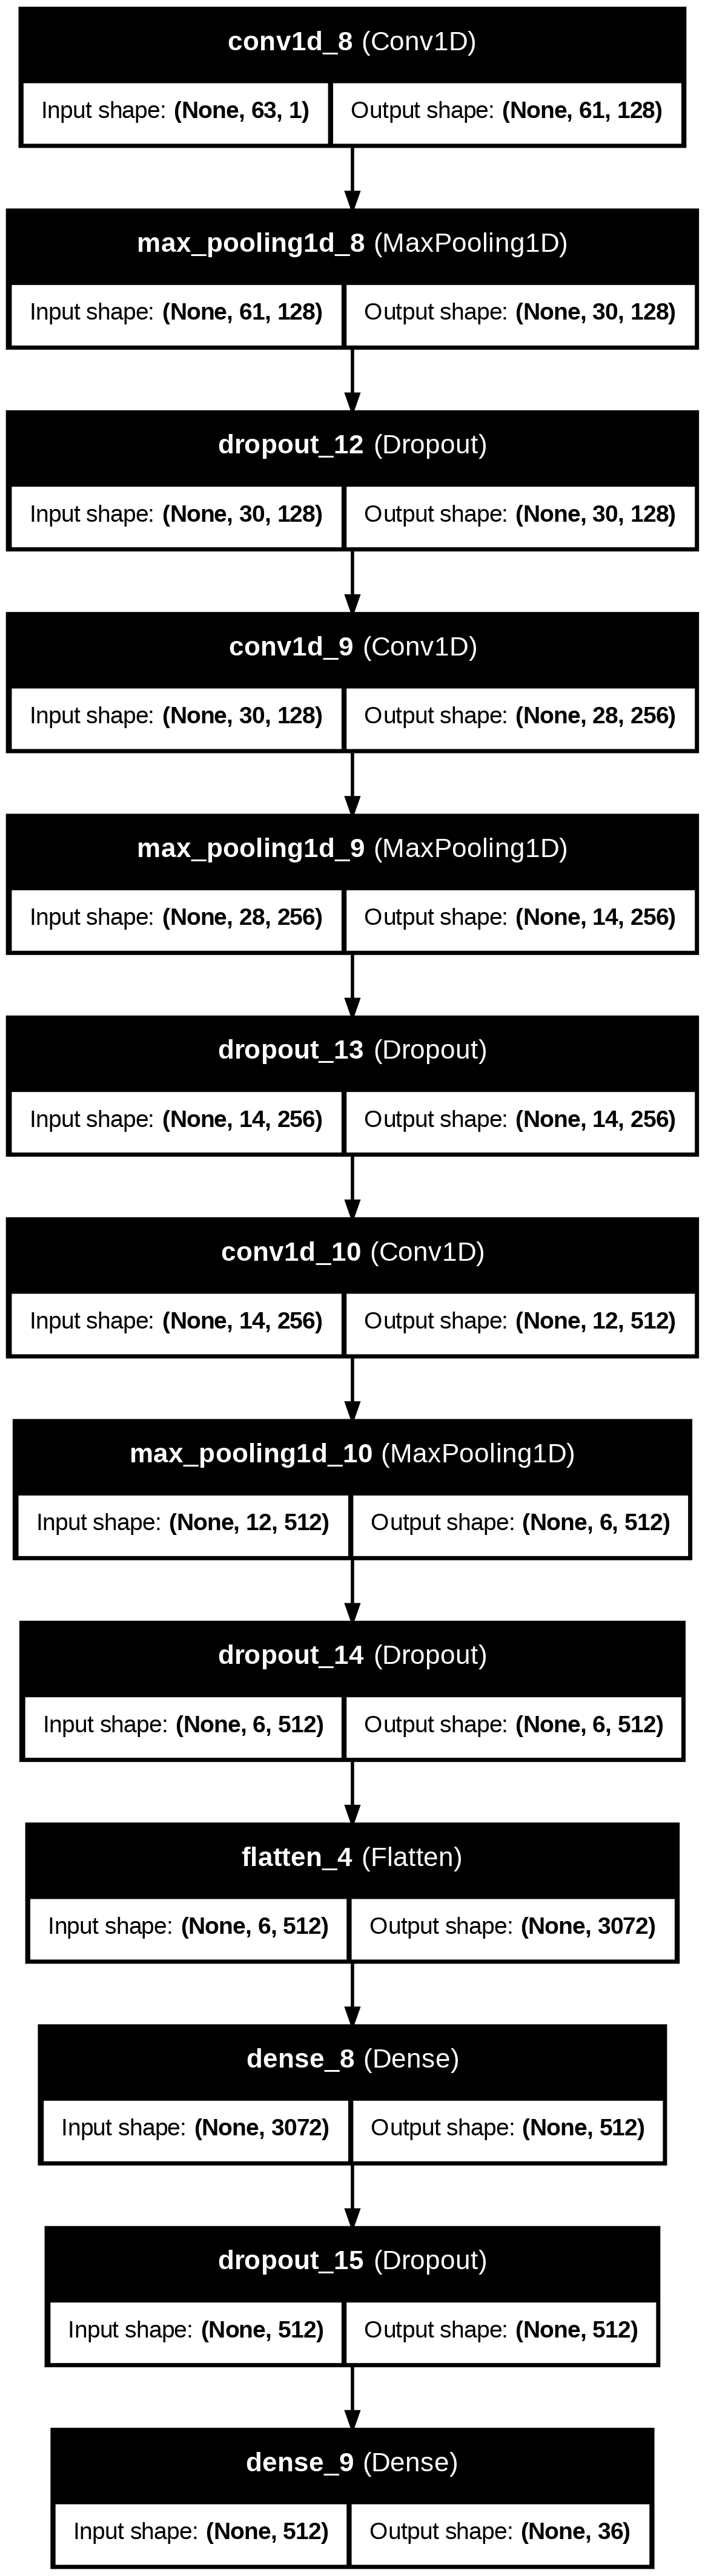

In [37]:

def get_advanced_cnn():
  cnn_model = Sequential()

  # Перший згортковий шар
  cnn_model.add(Conv1D(128, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
  cnn_model.add(MaxPooling1D(pool_size=2))
  cnn_model.add(Dropout(0.25))

  # Другий згортковий шар
  cnn_model.add(Conv1D(256, kernel_size=3, activation='relu'))
  cnn_model.add(MaxPooling1D(pool_size=2))
  cnn_model.add(Dropout(0.25))

  # Додавання третього згорткового шару
  cnn_model.add(Conv1D(512, kernel_size=3, activation='relu'))
  cnn_model.add(MaxPooling1D(pool_size=2))
  cnn_model.add(Dropout(0.25))

  # Розгортання (Flatten)
  cnn_model.add(Flatten())

  # Більше нейронів в повнозв'язковому шарі
  cnn_model.add(Dense(512, activation='relu'))
  cnn_model.add(Dropout(0.5))

  # Вихідний шар
  cnn_model.add(Dense(36, activation='softmax'))

  return cnn_model

# Компіляція моделі
model_advanced = get_advanced_cnn()
model_advanced.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
# Visualize the CNN model architecture
model_advanced.summary()

# Save model visualization to a file
plot_model(model_advanced, show_shapes=True, show_layer_names=True)

In [41]:
history = model_advanced.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=64)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 0.1047 - loss: 3.4431 - val_accuracy: 0.2708 - val_loss: 2.6492
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 0.3035 - loss: 2.6031 - val_accuracy: 0.5292 - val_loss: 1.8532
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.4586 - loss: 1.8475 - val_accuracy: 0.6954 - val_loss: 1.1580
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.6107 - loss: 1.2093 - val_accuracy: 0.8092 - val_loss: 0.7552
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.7288 - loss: 0.8836 - val_accuracy: 0.8615 - val_loss: 0.5487
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.7994 - loss: 0.6055 - val_accuracy: 0.8831 - val_loss: 0.4756
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 193ms/step - accuracy: 0.8298 - loss: 0.5144 - val_accuracy: 0.9077 - val_loss: 0.3955
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.8694 - loss: 0.4148 - val_accuracy: 0.

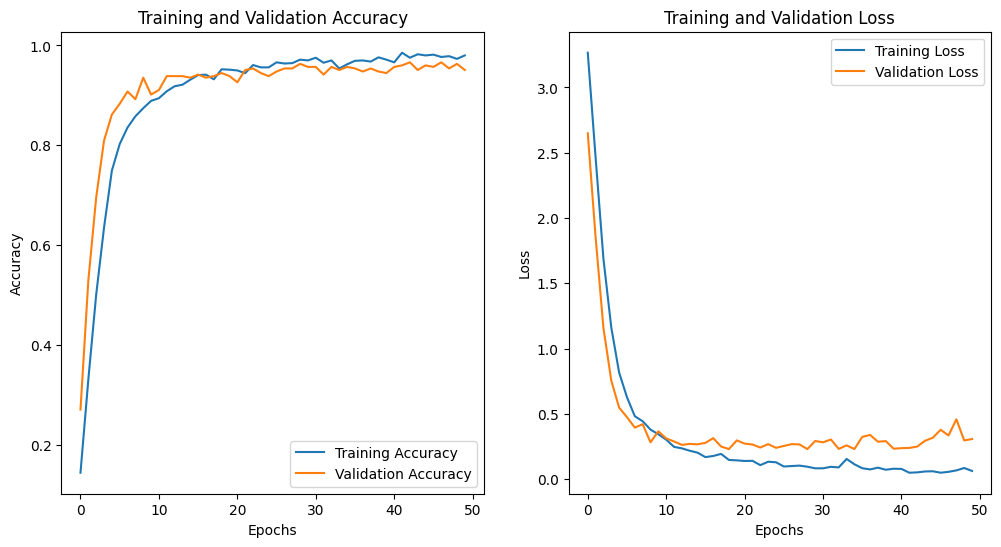

In [42]:
plot_learning_curves(history)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


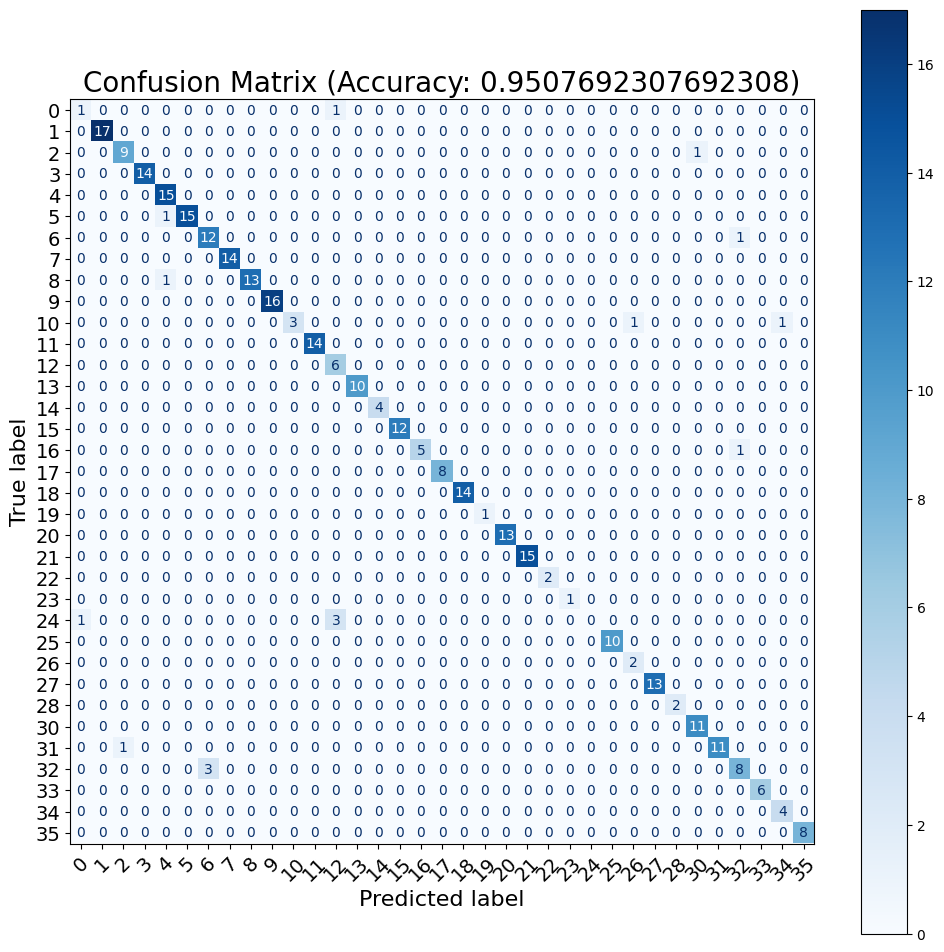

In [43]:
# Прогнозуємо на тестовому наборі
y_pred = model_advanced.predict(X_test)

# Перетворення one-hot encoded міток у вектори класів
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

plot_conf_matrix(y_true, y_pred_classes)

# Model Regularization

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_11 (Conv1D)                   │ (None, 61, 128)             │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_11 (MaxPooling1D)      │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_12 (Conv1D)                   │ (None, 28, 256)             │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_12 (MaxPooling1D)      │ (None, 14, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 14, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 3584)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │       1,835,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 36)                  │          18,468 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,953,060 (7.45 MB)

 Trainable params: 1,953,060 (7.45 MB)

 Non-trainable params: 0 (0.00 B)

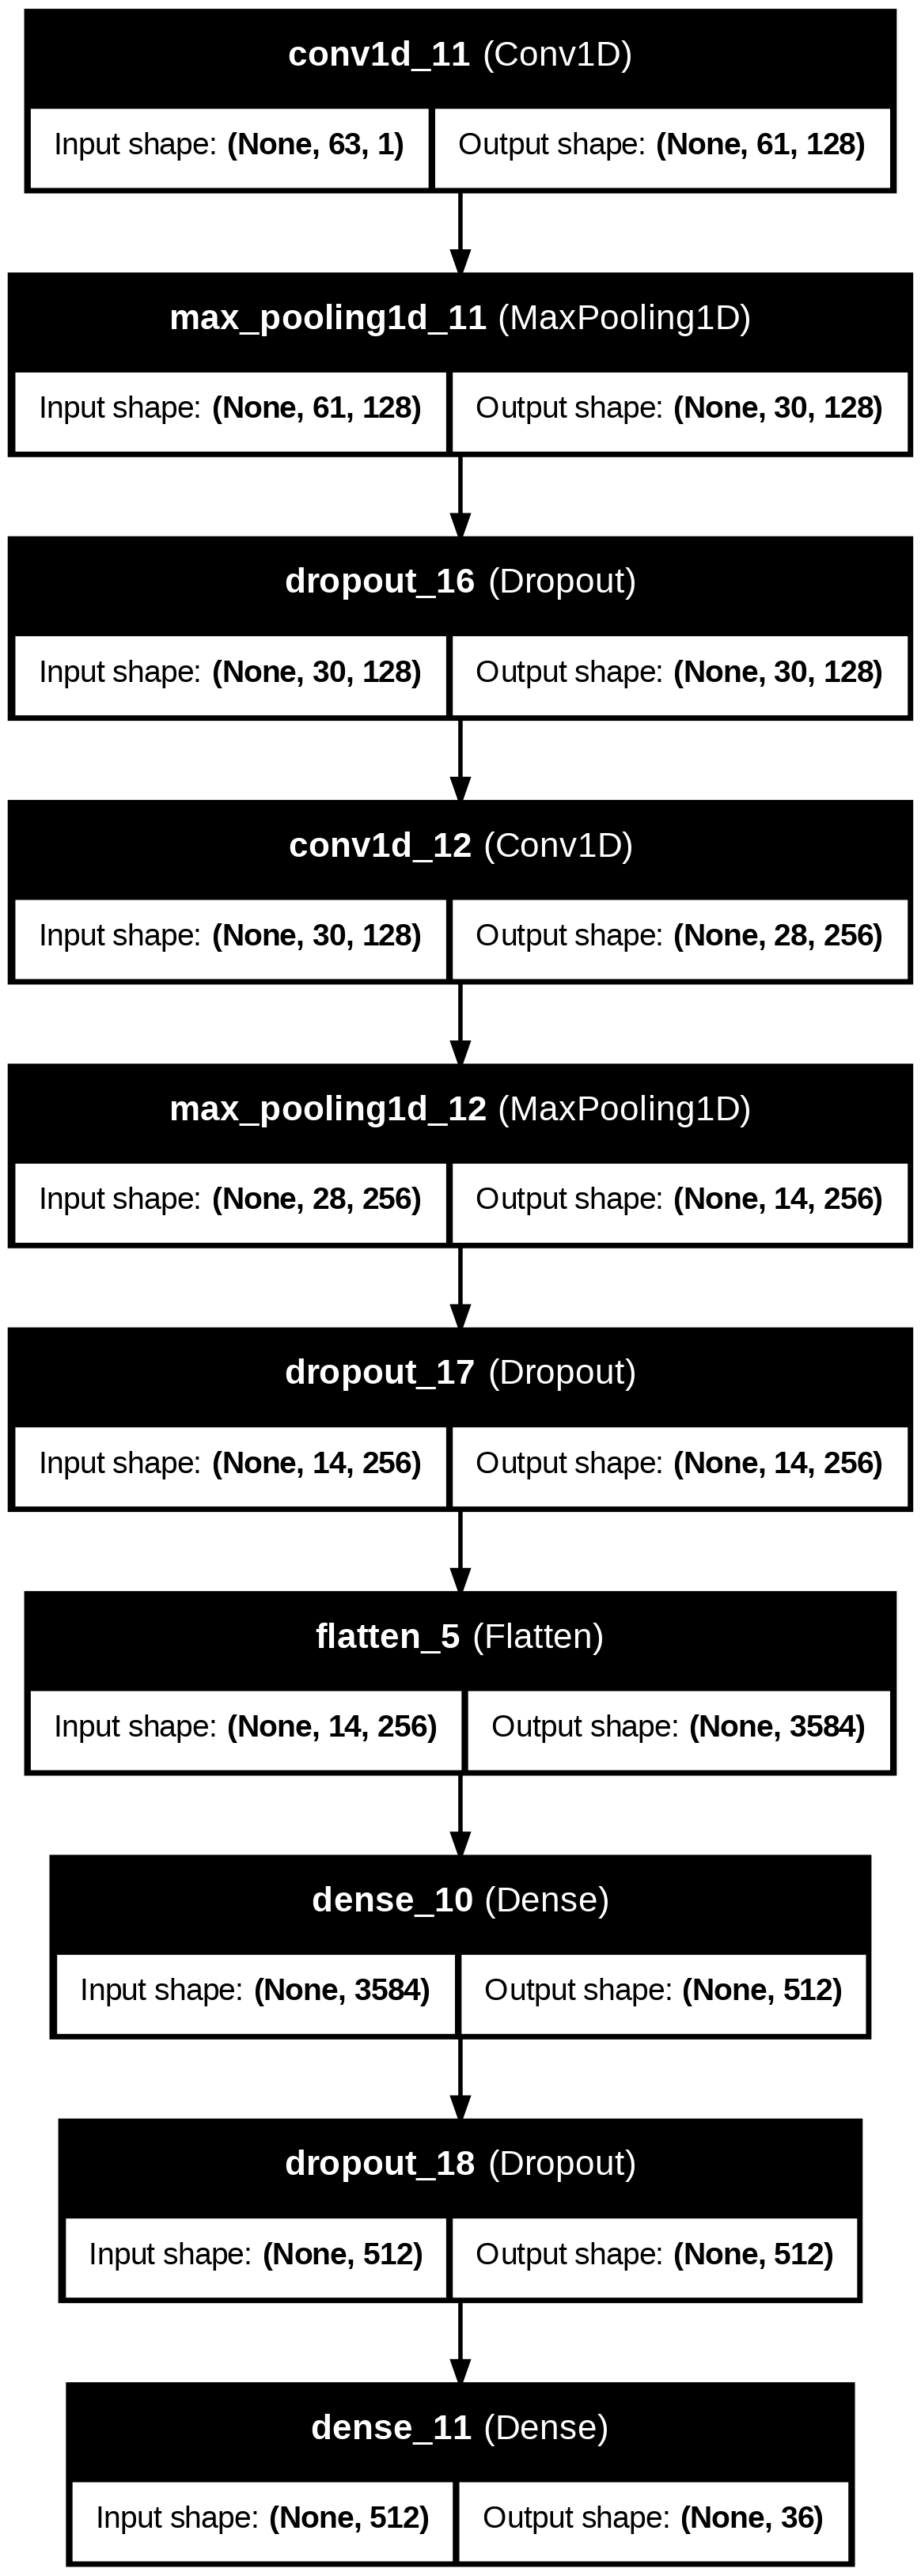

In [44]:
from tensorflow.keras.regularizers import l2

def get_regularized_cnn():

  cnn_model = Sequential()

  cnn_model.add(Conv1D(128, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1), kernel_regularizer=l2(0.001)))
  cnn_model.add(MaxPooling1D(pool_size=2))
  cnn_model.add(Dropout(0.3))

  cnn_model.add(Conv1D(256, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)))
  cnn_model.add(MaxPooling1D(pool_size=2))
  cnn_model.add(Dropout(0.3))

  cnn_model.add(Flatten())
  cnn_model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
  cnn_model.add(Dropout(0.4))

  cnn_model.add(Dense(36, activation='softmax'))

  return cnn_model

# Компіляція моделі
model_regularized = get_regularized_cnn()
model_regularized.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
# Visualize the CNN model architecture
model_regularized.summary()

# Save model visualization to a file
plot_model(model_regularized, show_shapes=True, show_layer_names=True)

In [45]:
history = model_regularized.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=64)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 167ms/step - accuracy: 0.1304 - loss: 4.3420 - val_accuracy: 0.5200 - val_loss: 2.8518
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.5147 - loss: 2.6954 - val_accuracy: 0.7323 - val_loss: 1.7972
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.7111 - loss: 1.7247 - val_accuracy: 0.8431 - val_loss: 1.4470
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.8055 - loss: 1.4167 - val_accuracy: 0.8862 - val_loss: 1.1833
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.8548 - loss: 1.1888 - val_accuracy: 0.9015 - val_loss: 1.0459
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.8943 - loss: 1.0500 - val_accuracy: 0.9200 - val_loss: 0.9780
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.8954 - loss: 0.9709 - val_accuracy: 0.9323 - val_loss: 0.8981
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.9060 - loss: 0.9056 - val_accuracy: 0.9323 

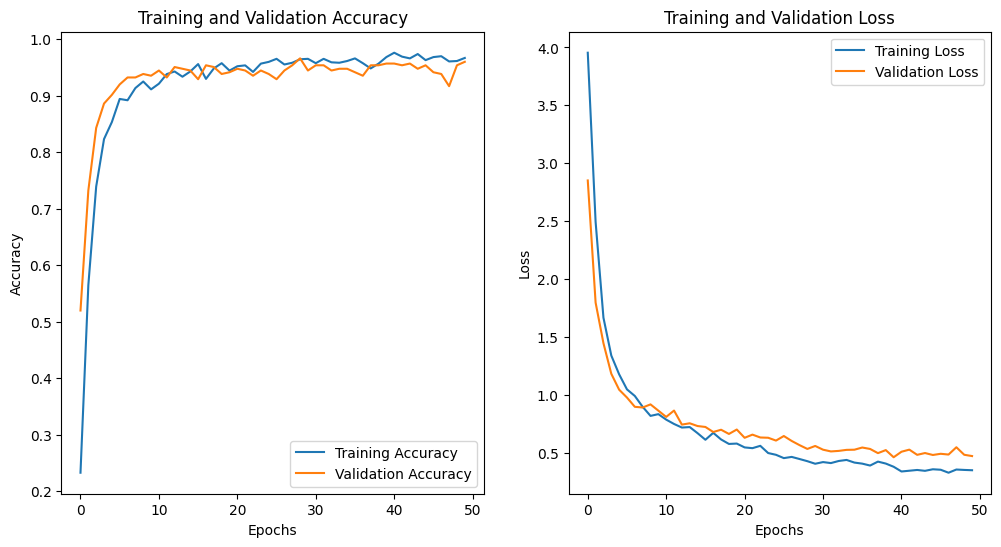

In [46]:
plot_learning_curves(history)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


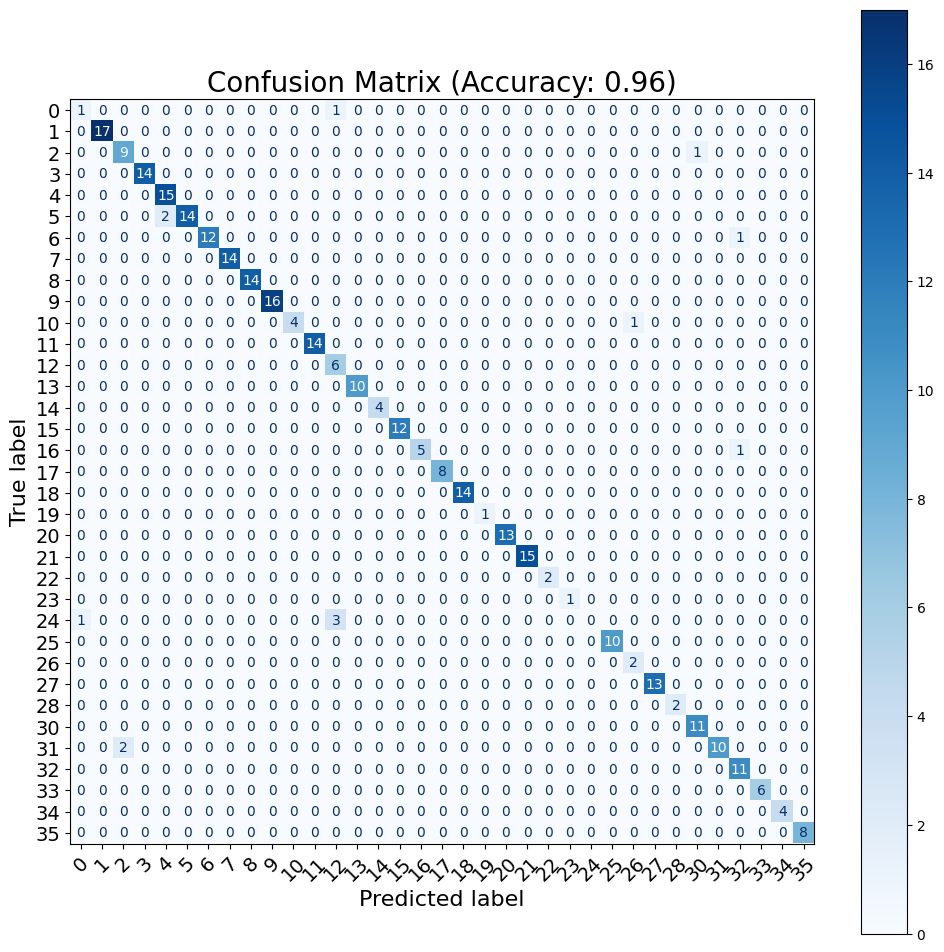

In [47]:
# Прогнозуємо на тестовому наборі
y_pred = model_regularized.predict(X_test)

# Перетворення one-hot encoded міток у вектори класів
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

plot_conf_matrix(y_true, y_pred_classes)

# Ансамбль моделей

In [50]:
def create_model_1():
    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(36, activation='softmax'))
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def create_model_2():
    model = Sequential()
    model.add(Conv1D(128, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))

    model.add(Conv1D(256, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(36, activation='softmax'))
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model



def create_model_3():
    model = Sequential()
    model.add(Conv1D(128, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1), kernel_regularizer=l2(0.001)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.4))

    model.add(Dense(36, activation='softmax'))
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [51]:
# Створення моделей
model_1 = create_model_1()
model_2 = create_model_2()
model_3 = create_model_3()

# Навчання моделей
history_1 = model_1.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=64)
history_2 = model_2.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=64)
history_3 = model_3.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=64)


Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.1197 - loss: 3.4055 - val_accuracy: 0.4585 - val_loss: 2.4862
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.4035 - loss: 2.3962 - val_accuracy: 0.6492 - val_loss: 1.5999
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5479 - loss: 1.7290 - val_accuracy: 0.7815 - val_loss: 1.0665
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6218 - loss: 1.3687 - val_accuracy: 0.8092 - val_loss: 0.7984
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7071 - loss: 0.9934 - val_accuracy: 0.8677 - val_loss: 0.6193
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7875 - loss: 0.7939 - val_accuracy: 0.8615 - val_loss: 0.5507
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7723 - loss: 0.7835 - val_accuracy: 0.8892 - val_loss: 0.4869
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8173 - loss: 0.6590 - val_accuracy: 0.8954 - v

In [52]:
# Прогнозування на тестовому наборі для кожної моделі
y_pred_1 = model_1.predict(X_test)
y_pred_2 = model_2.predict(X_test)
y_pred_3 = model_3.predict(X_test)

# Усереднення результатів (метод голосування)
y_pred_avg = (y_pred_1 + y_pred_2 + y_pred_3) / 3

# Перетворення прогнозованих ймовірностей у класові мітки
y_pred_classes = np.argmax(y_pred_avg, axis=1)
y_true = np.argmax(y_test, axis=1)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


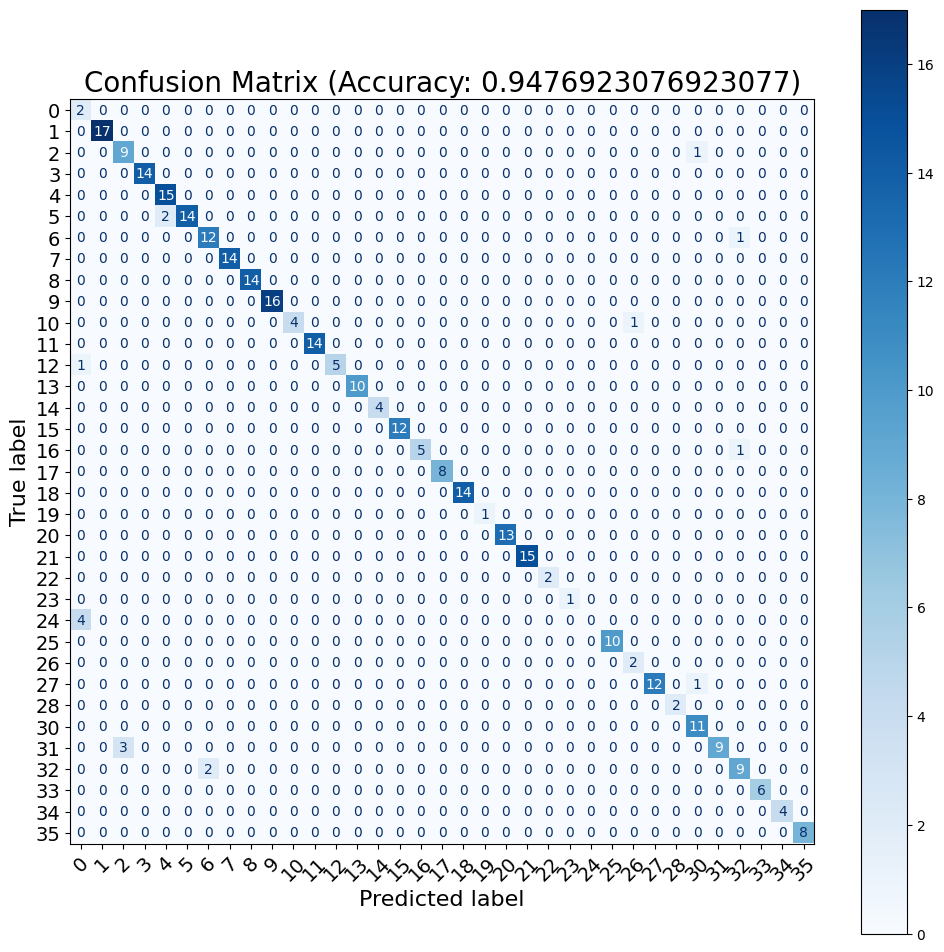

In [53]:
plot_conf_matrix(y_true, y_pred_classes)

# Model Regularization

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_11 (Conv1D)                   │ (None, 61, 128)             │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_11 (MaxPooling1D)      │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_12 (Conv1D)                   │ (None, 28, 256)             │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_12 (MaxPooling1D)      │ (None, 14, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 14, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 3584)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │       1,835,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 36)                  │          18,468 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,953,060 (7.45 MB)

 Trainable params: 1,953,060 (7.45 MB)

 Non-trainable params: 0 (0.00 B)

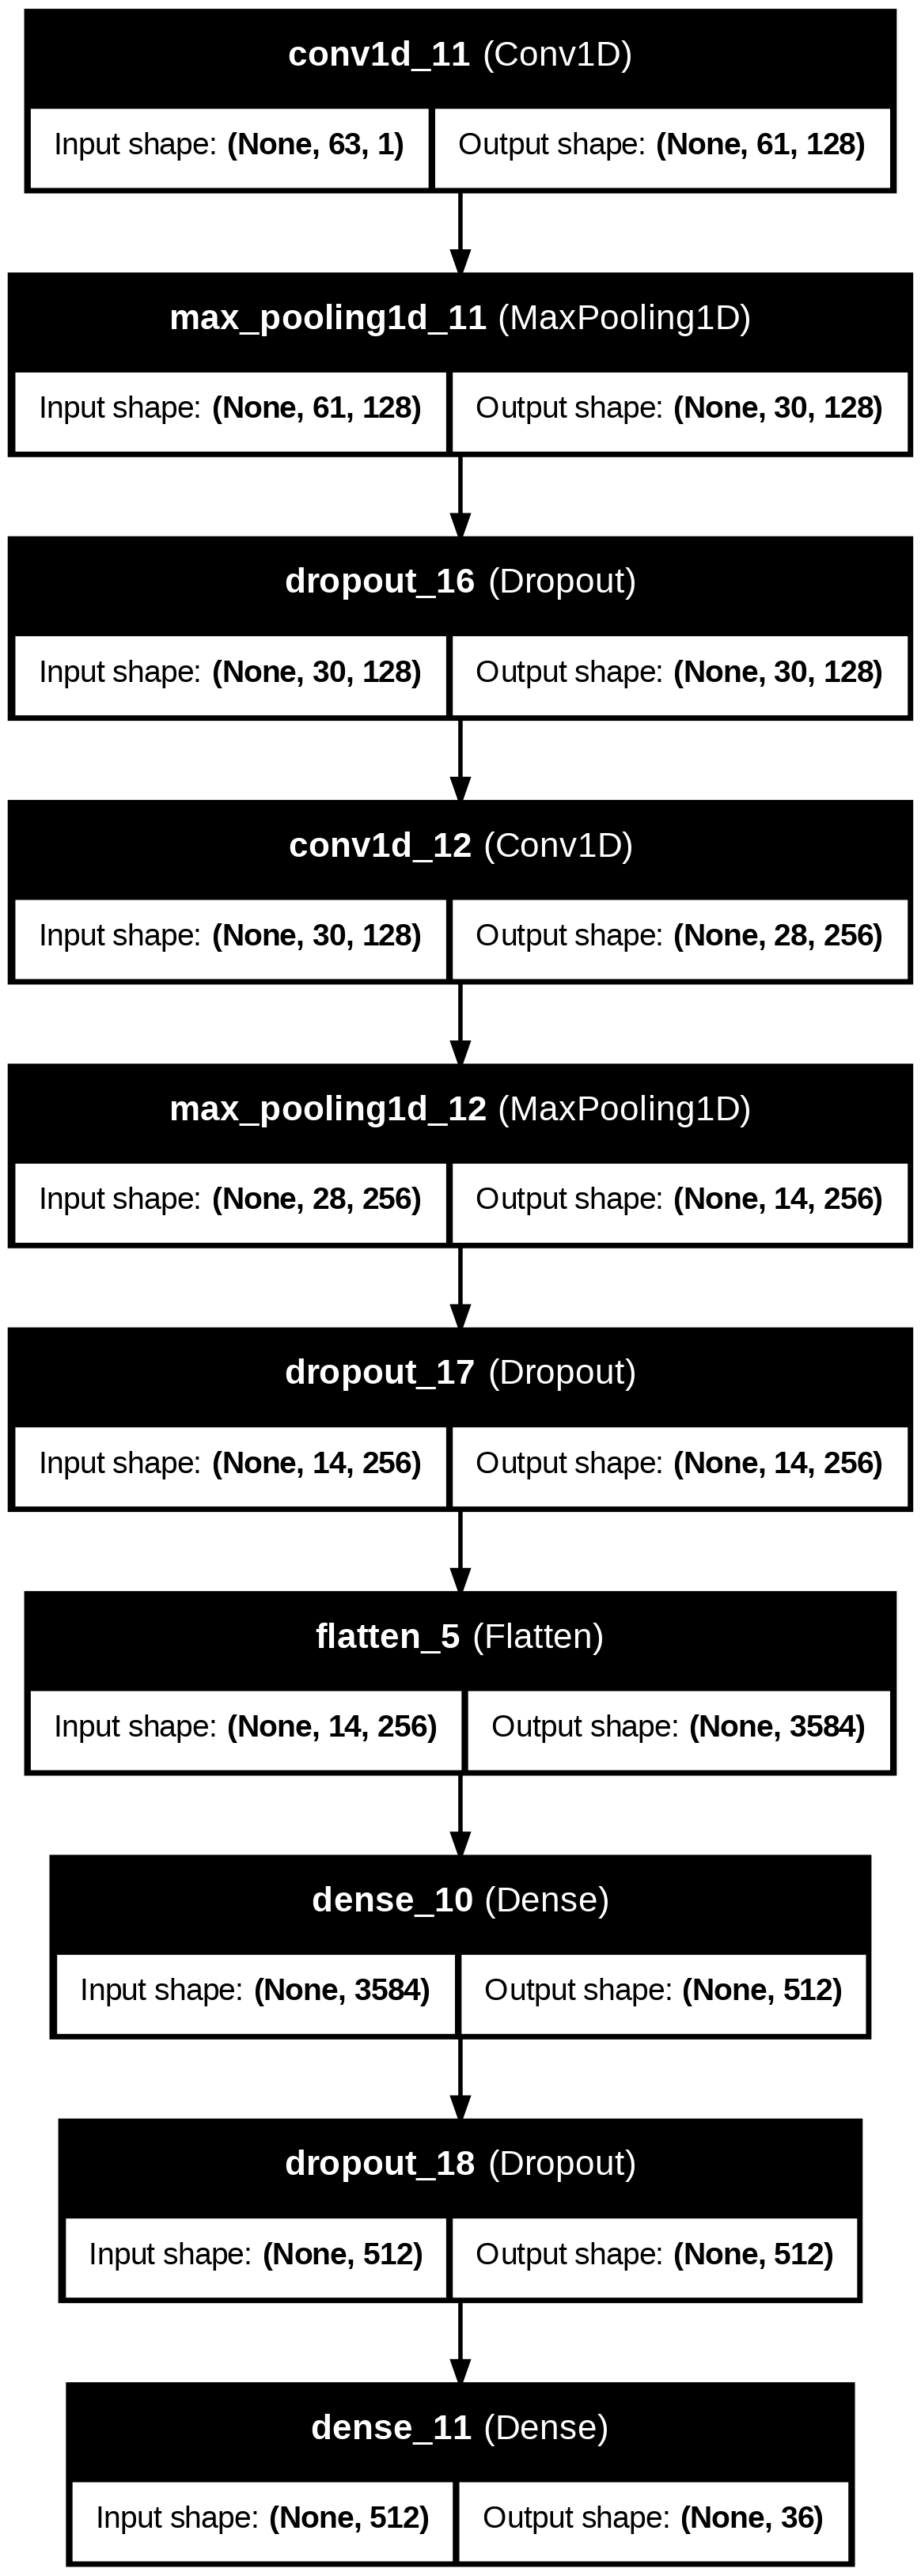

In [ ]:
from tensorflow.keras.regularizers import l2

def get_regularized_cnn():

  cnn_model = Sequential()

  cnn_model.add(Conv1D(128, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1), kernel_regularizer=l2(0.001)))
  cnn_model.add(MaxPooling1D(pool_size=2))
  cnn_model.add(Dropout(0.3))

  cnn_model.add(Conv1D(256, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)))
  cnn_model.add(MaxPooling1D(pool_size=2))
  cnn_model.add(Dropout(0.3))

  cnn_model.add(Flatten())
  cnn_model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
  cnn_model.add(Dropout(0.4))

  cnn_model.add(Dense(36, activation='softmax'))

  return cnn_model

# Компіляція моделі
model_regularized = get_regularized_cnn()
model_regularized.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
# Visualize the CNN model architecture
model_regularized.summary()

# Save model visualization to a file
plot_model(model_regularized, show_shapes=True, show_layer_names=True)

In [ ]:
history = model_regularized.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=64)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 167ms/step - accuracy: 0.1304 - loss: 4.3420 - val_accuracy: 0.5200 - val_loss: 2.8518
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.5147 - loss: 2.6954 - val_accuracy: 0.7323 - val_loss: 1.7972
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.7111 - loss: 1.7247 - val_accuracy: 0.8431 - val_loss: 1.4470
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.8055 - loss: 1.4167 - val_accuracy: 0.8862 - val_loss: 1.1833
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.8548 - loss: 1.1888 - val_accuracy: 0.9015 - val_loss: 1.0459
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.8943 - loss: 1.0500 - val_accuracy: 0.9200 - val_loss: 0.9780
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.8954 - loss: 0.9709 - val_accuracy: 0.9323 - val_loss: 0.8981
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.9060 - loss: 0.9056 - val_accuracy: 0.9323 

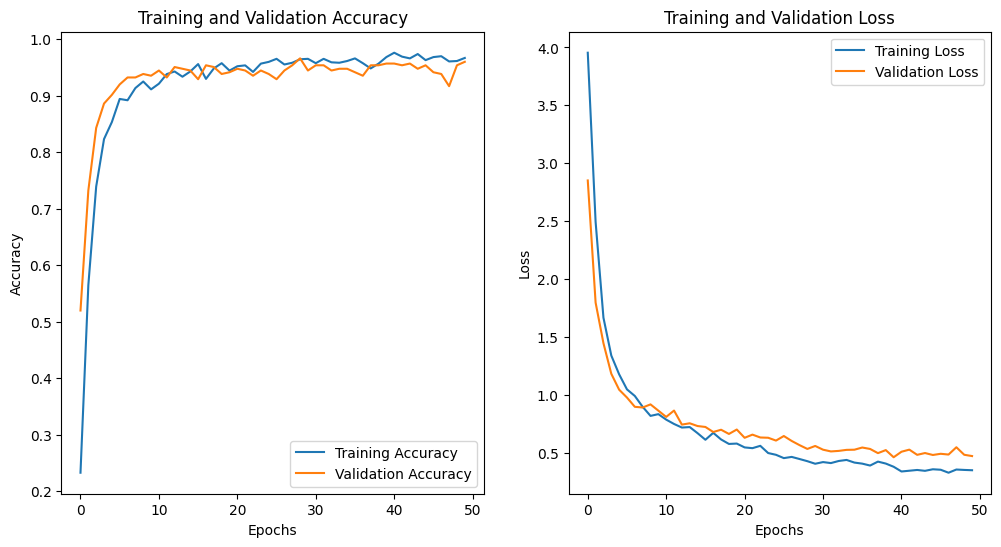

In [ ]:
plot_learning_curves(history)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


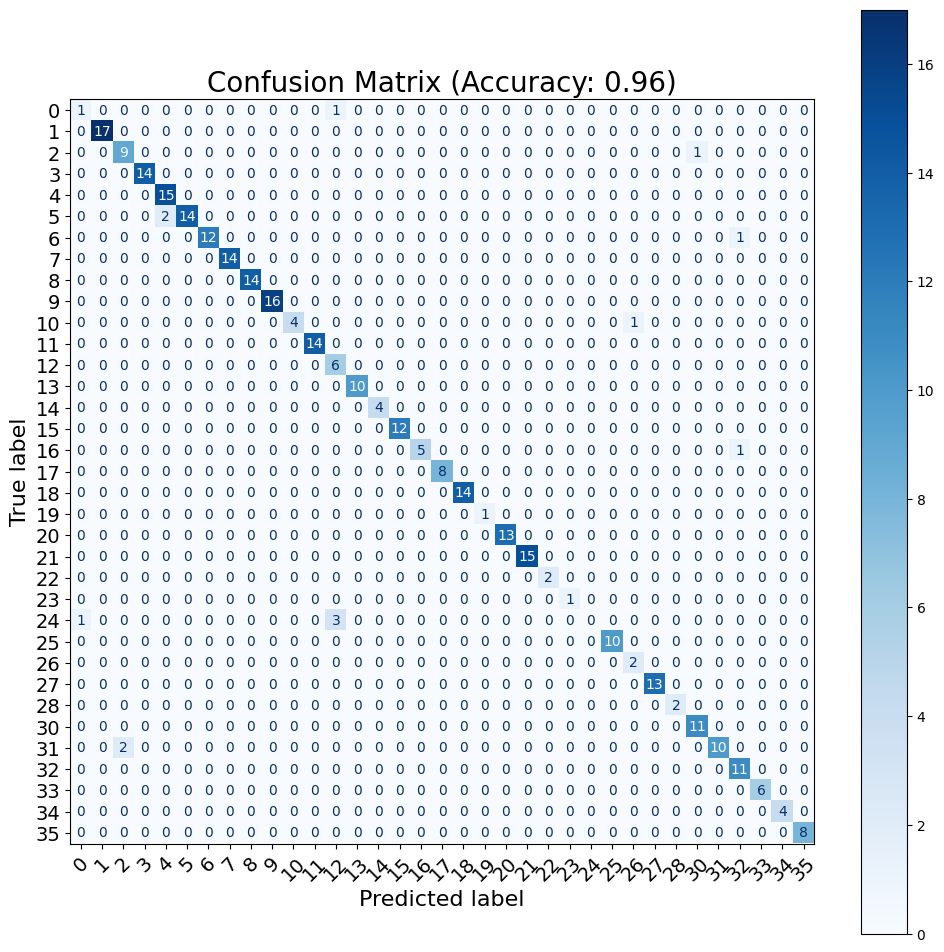

In [ ]:
# Прогнозуємо на тестовому наборі
y_pred = model_regularized.predict(X_test)

# Перетворення one-hot encoded міток у вектори класів
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

plot_conf_matrix(y_true, y_pred_classes)